In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
import sys
#PATH = '/content/drive/My Drive/PPM_Stability/'
#PATH = "C:/Users/velmurug/Documents/Stability Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/Mythreyi/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/mythr/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
PATH = "C:/Users/n9455647/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
sys.path.append(PATH)

In [2]:
from DatasetManager import DatasetManager

import pandas as pd
import numpy as np

import os
import sys
from sys import argv
import pickle
import random
import joblib

import statistics
import math

import warnings
warnings.filterwarnings('ignore')

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

lime_pal = sns.diverging_palette(100, 200, s=150)#, as_cmap=True)
shap_pal = sns.diverging_palette(0, 240, s=150)#, as_cmap=True)

sns.set_style('darkgrid')

In [4]:
dataset_ref = "production"
params_dir = PATH + "params"
results_dir = "results"
bucket_method = "prefix"
cls_encoding = "index"
cls_method = "xgboost"

gap = 1
n_iter = 1

method_name = "%s_%s"%(bucket_method, cls_encoding)

generate_samples = False
generate_lime = True
generate_kernel_shap = False
generate_model_shap = True

sample_size = 2
exp_iter = 10
max_feat = 10
max_prefix = 20

dataset_ref_to_datasets = {
    #"bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(5,6)],
    "bpic2017" : ["bpic2017_accepted"],
    "bpic2012" : ["bpic2012_accepted"],
    #"insurance": ["insurance_activity", "insurance_followup"],
    #"sepsis_cases": ["sepsis_cases_1", "sepsis_cases_2", "sepsis_cases_4"]
    "production" : ["production"]
}

datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]

datasets

['production']

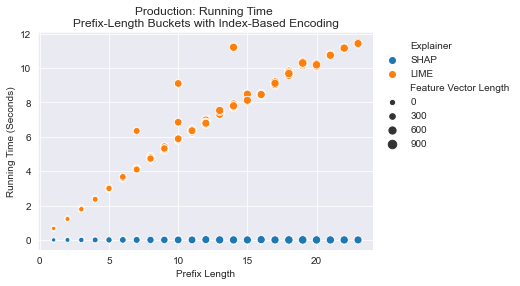

In [5]:
for dataset_name in datasets:
    sep_timing_path = os.path.join(PATH, "%s/%s_%s/sep_timing.csv" % (dataset_ref, cls_method, method_name))
    all_timing_path = os.path.join(PATH, "%s/%s_%s/all_timing.csv" % (dataset_ref, cls_method, method_name))
    
    sep_data = pd.read_csv(sep_timing_path)
    all_data = pd.read_csv(all_timing_path)
    
    time_plot = sns.scatterplot(x = all_data['Prefix Length'], y = all_data['Running Time'], hue = all_data['Explainer'], size = all_data['Feature Vector Length'])
    plt.xlabel("Prefix Length")
    plt.ylabel("Running Time (Seconds)")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,1.1, 0.1))
    #plt.ylim(0,1.1)
    plt.title("Production: Running Time \nPrefix-Length Buckets with Index-Based Encoding")
    plot = time_plot.get_figure()
    plot.savefig("figures/timing.png", bbox_inches = "tight")
    plt.show()

In [6]:
all_caseID = []
all_lengths = []
all_proba = []
all_lime_stab = []
all_shap_stab = []

for dataset_name in datasets:

    dataset_manager = DatasetManager(dataset_name)

    for ii in range(n_iter):
        num_buckets = len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))])
        
        if num_buckets < max_prefix:
            max_prefix = num_buckets
            
        buckets = range(0, max_prefix, gap)

        for bucket in buckets:
            bucketID = bucket+1
            print ('Bucket', bucketID)

            #import everything needed to sort and predict
            feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
            cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
            cls = joblib.load(cls_path)
            feature_combiner = joblib.load(feat_comb_path)

            #import previously identified samples
            tn_path = os.path.join(PATH, "%s/%s_%s/samples/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            tp_path = os.path.join(PATH, "%s/%s_%s/samples/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            fn_path = os.path.join(PATH, "%s/%s_%s/samples/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            fp_path = os.path.join(PATH, "%s/%s_%s/samples/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

            sample_instances = []

            with open (tn_path, 'rb') as f:
                tn_list = pickle.load(f)
            with open (tp_path, 'rb') as f:
                tp_list = pickle.load(f)
            with open (fn_path, 'rb') as f:
                fn_list = pickle.load(f)
            with open (fp_path, 'rb') as f:
                fp_list = pickle.load(f)

            #save results to a list
            sample_instances.append(tn_list)
            sample_instances.append(tp_list)
            sample_instances.append(fn_list)
            sample_instances.append(fp_list)
            
            type_list = ["True Negatives", "True Positives", "False Negatives", "False Positives"]
            
            for i in range(len(sample_instances)):
                print (type_list[i])
                if sample_instances[i]!=[]:
                    data = pd.DataFrame.from_records(sample_instances[i])

                    case_id = pd.Series(data['caseID'])
                    nr_events = pd.Series(data['nr_events'])
                    proba = pd.Series(data['proba'])
                    lime_stability = pd.Series(data['lime_stability'])
                    tree_shap_stability = pd.Series(data['tree_shap_stability'])

                    all_caseID.extend(case_id)
                    all_lengths.extend(nr_events)
                    all_proba.extend(proba)
                    all_lime_stab.extend(lime_stability)
                    all_shap_stab.extend(tree_shap_stability)

                    print("Average LIME Stability:", statistics.mean(lime_stability))
                    print("Average SHAP Stability:", statistics.mean(tree_shap_stability))

                    #fig, ax = plt.subplots()
                    #ax.plot(nr_events, lime_stability, 'bo', label = "LIME")
                    #ax.plot(nr_events, tree_shap_stability, 'ro', label = "Tree SHAP")
                    #ax.set_xlabel("Prefix Length")
                    #ax.set_ylabel("Stability")
                    #ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    #plt.yticks(np.arange(0,1, 0.1))
                    #plt.title("Prefix length and stability by index - "+type_list[i])
                    #plt.show()

                    #fig2, ax2 = plt.subplots()
                    #ax2.plot(proba, lime_stability, 'bo', label = "LIME")
                    #ax2.plot(proba, tree_shap_stability, 'ro', label = "Tree SHAP")
                    #ax2.set_xlabel("Prediction Probability")
                    #ax2.set_ylabel("Stability")
                    #ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    #plt.yticks(np.arange(0,1, 0.1))
                    #plt.title("Prediction probability and stability by index - "+type_list[i])
                    #plt.show()

Bucket 1
True Negatives
Average LIME Stability: 0.6390123456790123
Average SHAP Stability: 1.0
True Positives
Average LIME Stability: 0.6802469135802469
Average SHAP Stability: 1.0
False Negatives
Average LIME Stability: 0.6595679012345679
Average SHAP Stability: 1.0
False Positives
Average LIME Stability: 0.6342592592592593
Average SHAP Stability: 1.0
Bucket 2
True Negatives
Average LIME Stability: 0.700920099726702
Average SHAP Stability: 1.0
True Positives
Average LIME Stability: 0.6551533766112793
Average SHAP Stability: 1.0
False Negatives
Average LIME Stability: 0.6715523059808043
Average SHAP Stability: 1.0
False Positives
Average LIME Stability: 0.6733267017635265
Average SHAP Stability: 1.0
Bucket 3
True Negatives
Average LIME Stability: 0.5501217007208571
Average SHAP Stability: 1.0
True Positives
Average LIME Stability: 0.569350038206544
Average SHAP Stability: 1.0
False Negatives
Average LIME Stability: 0.5416850402426046
Average SHAP Stability: 1.0
False Positives
Average 

In [7]:
max_len = max(all_lengths)
bins = np.arange(0, max_len+10, 5)
labels = []
for i in range(len(bins)-1):
    start = str(int(bins[i]+1))
    end = str(int(bins[i+1]))
    label = start+"-"+end+" prefixes"
    labels.append(label)

hue_lens = []
for length in all_lengths:
    cur_bin = 0
    while length >= bins[cur_bin+1]:
        cur_bin += 1
    hue_lens.append(labels[cur_bin])
#hue_lens

sorted_lists = sorted(zip(all_proba, all_lime_stab, all_shap_stab, all_lengths, hue_lens), key=lambda x: x[3])
all_proba, all_lime_stab, all_shap_stab, all_lengths, hue_lens = [[x[i] for x in sorted_lists] for i in range(len(sorted_lists[0]))]

In [8]:
pal_len = len(set(hue_lens))

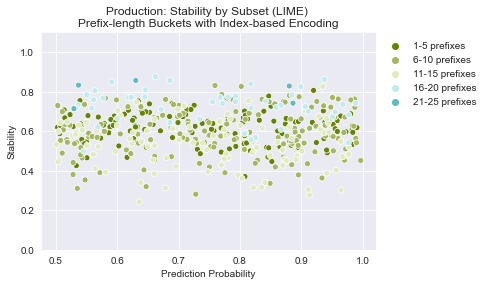

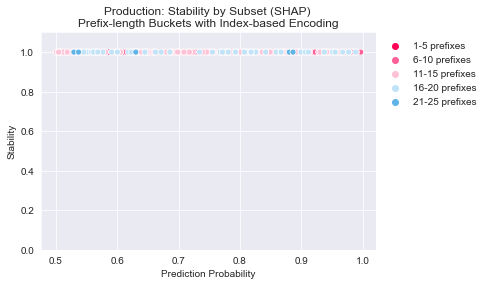

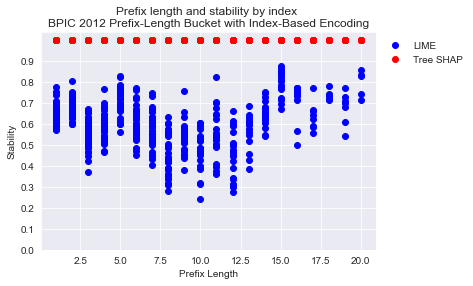

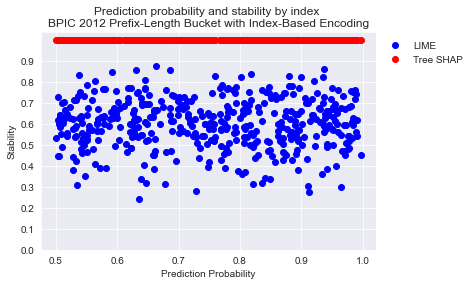

In [9]:
lime_scat = sns.scatterplot(all_proba, all_lime_stab, hue=hue_lens, palette=lime_pal[:pal_len])
plt.xlabel("Prediction Probability")
plt.ylabel("Stability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,1.1, 0.1))
plt.ylim(0,1.1)
plt.title("Production: Stability by Subset (LIME) \nPrefix-length Buckets with Index-based Encoding")
plot = lime_scat.get_figure()
plot.savefig("figures/lime_subset_stability.png", bbox_inches = "tight")
plt.show()

shap_scat = sns.scatterplot(all_proba, all_shap_stab, hue=hue_lens, palette=shap_pal[:pal_len])
plt.xlabel("Prediction Probability")
plt.ylabel("Stability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.ylim(0,1.1)
plt.title("Production: Stability by Subset (SHAP) \nPrefix-length Buckets with Index-based Encoding")
plot = shap_scat.get_figure()
plot.savefig("figures/shap_subset_stability.png", bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots()
ax.plot(all_lengths, all_lime_stab, 'bo', label = "LIME")
ax.plot(all_lengths, all_shap_stab, 'ro', label = "Tree SHAP")
ax.set_xlabel("Prefix Length")
ax.set_ylabel("Stability")
ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1, 0.1))
plt.title("Prefix length and stability by index \nBPIC 2012 Prefix-Length Bucket with Index-Based Encoding")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(all_proba, all_lime_stab, 'bo', label = "LIME")
ax2.plot(all_proba, all_shap_stab, 'ro', label = "Tree SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Stability")
ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1, 0.1))
plt.title("Prediction probability and stability by index \nBPIC 2012 Prefix-Length Bucket with Index-Based Encoding")
plt.show()

In [10]:
all_caseID = []
all_lengths = []
all_proba = []
all_lime_stab = []
all_shap_stab = []

for dataset_name in datasets:

    dataset_manager = DatasetManager(dataset_name)

    for ii in range(n_iter):
        num_buckets = len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))])
        
        if num_buckets < max_prefix:
            max_prefix = num_buckets
            
        buckets = range(0, max_prefix, gap)

        for bucket in buckets:
            bucketID = bucket+1
            print ('Bucket', bucketID)

            #import everything needed to sort and predict
            feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
            cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
            cls = joblib.load(cls_path)
            feature_combiner = joblib.load(feat_comb_path)

            #import previously identified samples
            tn_path = os.path.join(PATH, "%s/%s_%s/samples/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            tp_path = os.path.join(PATH, "%s/%s_%s/samples/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            fn_path = os.path.join(PATH, "%s/%s_%s/samples/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            fp_path = os.path.join(PATH, "%s/%s_%s/samples/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

            sample_instances = []

            with open (tn_path, 'rb') as f:
                tn_list = pickle.load(f)
            with open (tp_path, 'rb') as f:
                tp_list = pickle.load(f)
            with open (fn_path, 'rb') as f:
                fn_list = pickle.load(f)
            with open (fp_path, 'rb') as f:
                fp_list = pickle.load(f)

            #save results to a list
            sample_instances.append(tn_list)
            sample_instances.append(tp_list)
            sample_instances.append(fn_list)
            sample_instances.append(fp_list)
            
            type_list = ["True Negatives", "True Positives", "False Negatives", "False Positives"]
            
            for i in range(len(sample_instances)):
                print (type_list[i])
                if sample_instances[i]!=[]:
                    data = pd.DataFrame.from_records(sample_instances[i])

                    dispersal_lime = []
                    dispersal_shap = []
                    adj_dispersal_lime = []
                    adj_dispersal_shap = []

                    case_id = pd.Series(data['caseID'])
                    nr_events = pd.Series(data['nr_events'])
                    proba = pd.Series(data['proba'])
                    lime_stability = pd.Series(data['adjusted_lime_importance_stability'])
                    tree_shap_stability = pd.Series(data['adjusted_shap_importance_stability'])

                    all_caseID.extend(case_id)
                    all_lengths.extend(nr_events)
                    all_proba.extend(proba)
                    all_lime_stab.extend(lime_stability)
                    all_shap_stab.extend(tree_shap_stability)

                    print("Average LIME Weights Stability:", statistics.mean(lime_stability))
                    print("Average SHAP Weights Stability:", statistics.mean(tree_shap_stability))

                    shap_dispersion = [disp for disp in tree_shap_stability if disp > 0]

                    print (len(shap_dispersion))

                    #fig, ax = plt.subplots()
                    #ax.plot(nr_events, lime_stability, 'bo', label = "LIME")
                    #ax.plot(nr_events, tree_shap_stability, 'ro', label = "Tree SHAP")
                    #ax.set_xlabel("Prefix Length")
                    #ax.set_ylabel("Stability")
                    #ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    #plt.title("Prefix length and stability by weight - "+type_list[i])
                    #plt.show()

                    #fig2, ax2 = plt.subplots()
                    #ax2.plot(proba, lime_stability, 'bo', label = "LIME")
                    #ax2.plot(proba, tree_shap_stability, 'ro', label = "Tree SHAP")
                    #ax2.set_xlabel("Prediction Probability")
                    #ax2.set_ylabel("Stability")
                    #ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    #plt.title("Prediction probability and stability by weight - "+type_list[i])
                    #plt.show()

Bucket 1
True Negatives
Average LIME Weights Stability: 0.8928844678285193
Average SHAP Weights Stability: 0.9999999999999999
10
True Positives
Average LIME Weights Stability: 0.9030207097472479
Average SHAP Weights Stability: 0.9999999999999999
10
False Negatives
Average LIME Weights Stability: 0.9691879252837756
Average SHAP Weights Stability: 0.9999999999999999
8
False Positives
Average LIME Weights Stability: 0.9524831333084689
Average SHAP Weights Stability: 0.9999999999999999
8
Bucket 2
True Negatives
Average LIME Weights Stability: 0.9390195044990163
Average SHAP Weights Stability: 0.9999999999999999
10
True Positives
Average LIME Weights Stability: 0.9242161107975961
Average SHAP Weights Stability: 0.9999999999999999
10
False Negatives
Average LIME Weights Stability: 0.9494979962592679
Average SHAP Weights Stability: 0.9999999999999999
8
False Positives
Average LIME Weights Stability: 0.8492828327351408
Average SHAP Weights Stability: 0.9999999999999999
8
Bucket 3
True Negative

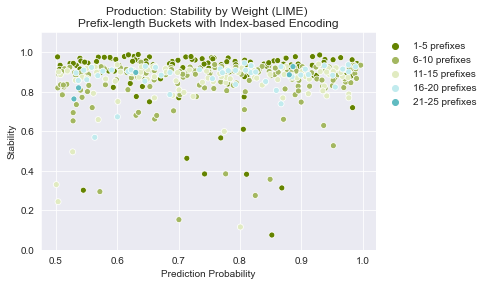

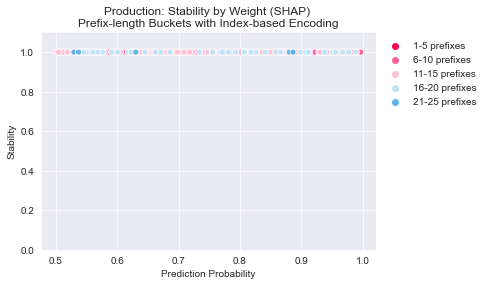

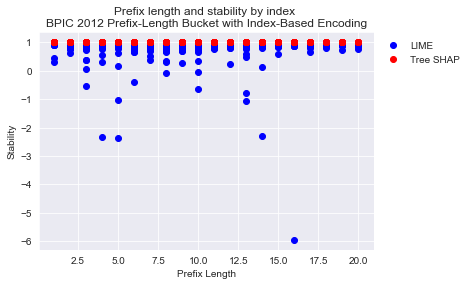

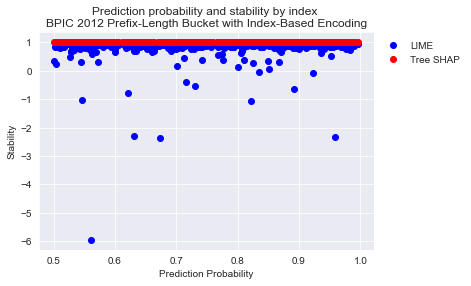

In [11]:
sns.scatterplot(all_proba, all_lime_stab, hue=hue_lens, palette=lime_pal[:pal_len])
plt.xlabel("Prediction Probability")
plt.ylabel("Stability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.ylim(0,1.1)
plt.title("Production: Stability by Weight (LIME) \nPrefix-length Buckets with Index-based Encoding")
plt.show()

sns.scatterplot(all_proba, all_shap_stab, hue=hue_lens, palette=shap_pal[:pal_len])
plt.xlabel("Prediction Probability")
plt.ylabel("Stability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.ylim(0,1.1)
plt.title("Production: Stability by Weight (SHAP) \nPrefix-length Buckets with Index-based Encoding")
plt.show()

fig, ax = plt.subplots()
ax.plot(all_lengths, all_lime_stab, 'bo', label = "LIME")
ax.plot(all_lengths, all_shap_stab, 'ro', label = "Tree SHAP")
ax.set_xlabel("Prefix Length")
ax.set_ylabel("Stability")
ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,15,1))
plt.title("Prefix length and stability by index \nBPIC 2012 Prefix-Length Bucket with Index-Based Encoding")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(all_proba, all_lime_stab, 'bo', label = "LIME")
ax2.plot(all_proba, all_shap_stab, 'ro', label = "Tree SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Stability")
ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,15,1))
plt.title("Prediction probability and stability by index \nBPIC 2012 Prefix-Length Bucket with Index-Based Encoding")
plt.show()

In [12]:
lime_mean = np.mean(all_lime_stab)
lime_std = np.std(all_lime_stab)
lime_upper = lime_mean + (3*lime_std)
lime_lower = lime_mean - (3*lime_std)

shap_mean = np.mean(all_shap_stab)
shap_std = np.std(all_shap_stab)
shap_upper = shap_mean + (3*shap_std)
shap_lower = shap_mean - (3*shap_std)

lime_outliers = [i for i in all_lime_stab if i > lime_upper or i < lime_lower]
shap_outliers = [i for i in all_shap_stab if i > shap_upper or i < shap_lower]

print (lime_mean)
print (shap_mean)
print(len(lime_outliers))
print(len(shap_outliers))
print(str(len(lime_outliers)/len(all_lime_stab)*100)+"%")
print(str(len(shap_outliers)/len(all_shap_stab)*100)+"%")

0.7984736886684136
1.0
8
0
1.805869074492099%
0.0%


In [13]:
max_len = max(all_lengths)
bins = np.arange(0, max_len+10, 5)
labels = []
for i in range(len(bins)-1):
    start = str(int(bins[i]+1))
    end = str(int(bins[i+1]))
    label = start+"-"+end+" prefixes"
    labels.append(label)

hue_lens = []
for length in all_lengths:
    cur_bin = 0
    while length >= bins[cur_bin+1]:
        cur_bin += 1
    hue_lens.append(labels[cur_bin])
#hue_lens

sorted_lists = sorted(zip(all_proba, all_lime_stab, all_shap_stab, all_lengths, hue_lens), key=lambda x: x[3])
all_proba, all_lime_stab, all_shap_stab, all_lengths, hue_lens = [[x[i] for x in sorted_lists] for i in range(len(sorted_lists[0]))]

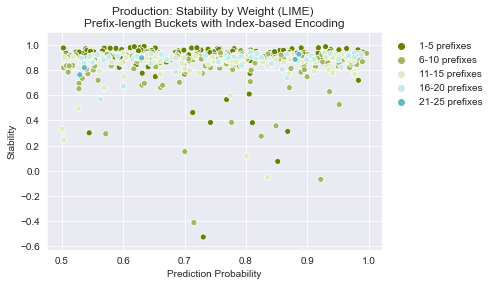

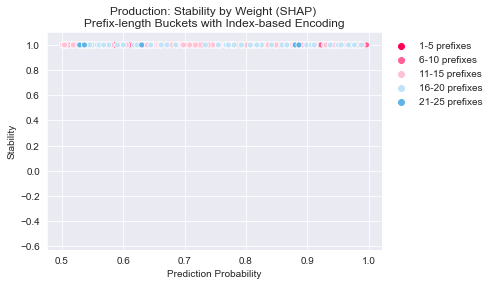

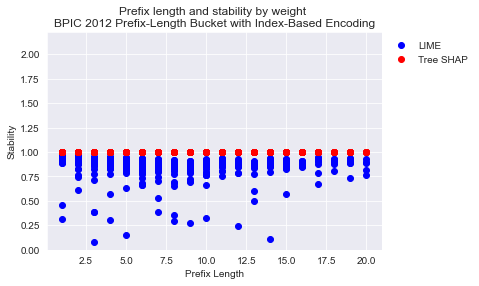

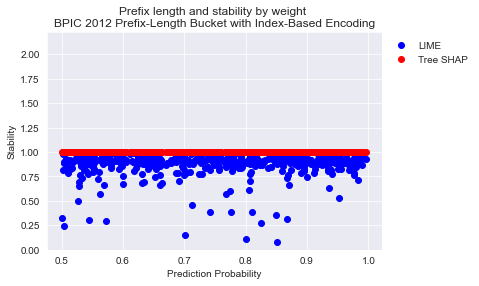

In [14]:
lime_scat = sns.scatterplot(all_proba, all_lime_stab, hue=hue_lens, palette=lime_pal[:pal_len])
plt.xlabel("Prediction Probability")
plt.ylabel("Stability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,1.1, 0.1))
plt.ylim(lime_lower,1.1)
plt.title("Production: Stability by Weight (LIME) \nPrefix-length Buckets with Index-based Encoding")
plot = lime_scat.get_figure()
plot.savefig("figures/lime_weight_stability.png", bbox_inches = "tight")
plt.show()

shap_scat = sns.scatterplot(all_proba, all_shap_stab, hue=hue_lens, palette=shap_pal[:pal_len])
plt.xlabel("Prediction Probability")
plt.ylabel("Stability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,1, 0.1))
plt.ylim(lime_lower,1.1)
plt.title("Production: Stability by Weight (SHAP) \nPrefix-length Buckets with Index-based Encoding")
plot = shap_scat.get_figure()
plot.savefig("figures/shap_weight_stability.png", bbox_inches = "tight")
plt.show()

fig, ax = plt.subplots()
ax.plot(all_lengths, all_lime_stab, 'bo', label = "LIME")
ax.plot(all_lengths, all_shap_stab, 'ro', label = "Tree SHAP")
ax.set_xlabel("Prefix Length")
ax.set_ylabel("Stability")
ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,15,1))
plt.ylim(0, lime_upper)
plt.title("Prefix length and stability by weight \nBPIC 2012 Prefix-Length Bucket with Index-Based Encoding")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(all_proba, all_lime_stab, 'bo', label = "LIME")
ax2.plot(all_proba, all_shap_stab, 'ro', label = "Tree SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Stability")
ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,15,1))
plt.ylim(0, lime_upper)
plt.title("Prefix length and stability by weight \nBPIC 2012 Prefix-Length Bucket with Index-Based Encoding")
plt.show()

In [15]:
# bins = np.arange(0, shap_upper+1e-17, 1e-17)
# yticks = np.arange(0, 120, 10)
# #sns.set_style("white")
# plt.subplots(figsize=(20, 15))
# plt.hist(all_shap_stab, bins = bins)
# #plt.figsize([50, 50])
# plt.xticks(bins, fontsize = 8)
# plt.yticks(yticks, fontsize = 12)
# plt.title("Distribution of SHAP Stability by Weight", fontsize = 16)
# plt.xlabel("Stability Range", fontsize = 14)
# plt.ylabel("Frequency", fontsize = 14)
# plt.show()

In [16]:
# bins = np.arange(0, lime_upper+0.1, 0.1)
# yticks = np.arange(0, 720, 20)
# #sns.set_style("white")
# plt.subplots(figsize=(10, 10))
# plt.hist(all_lime_stab, bins = bins)
# #plt.figsize([50, 50])
# plt.xticks(bins, fontsize = 12)
# plt.yticks(yticks, fontsize = 12)
# plt.title("Distribution of LIME Stability by Weight", fontsize = 16)
# plt.xlabel("Stability Range", fontsize = 14)
# plt.ylabel("Frequency", fontsize = 14)
# plt.show()

In [17]:
all_caseID = []
all_lengths = []
all_proba = []

sep_caseID = [[],[],[],[]]
sep_lengths = [[],[],[],[]]
sep_proba = [[],[],[],[]]

all_lime_diffs = []
all_shap_diffs = []

sep_lime_diffs = [[],[],[],[]]
sep_shap_diffs = [[],[],[],[]]

all_lime_MSE = []
all_lime_RMSE = []
all_lime_MAE = []
all_lime_MAPE = []

sep_lime_MSE = [[],[],[],[]]
sep_lime_RMSE = [[],[],[],[]]
sep_lime_MAE = [[],[],[],[]]
sep_lime_MAPE = [[],[],[],[]]

all_shap_MSE = []
all_shap_RMSE = []
all_shap_MAE = []
all_shap_MAPE = []

sep_shap_MSE = [[],[],[],[]]
sep_shap_RMSE = [[],[],[],[]]
sep_shap_MAE = [[],[],[],[]]
sep_shap_MAPE = [[],[],[],[]]

for dataset_name in datasets:

    dataset_manager = DatasetManager(dataset_name)

    for ii in range(n_iter):
        num_buckets = len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))])
        
        if num_buckets < max_prefix:
            max_prefix = num_buckets
            
        buckets = range(0, max_prefix, gap)

        for bucket in buckets:
            bucketID = bucket+1
            print ('Bucket', bucketID)

            #import everything needed to sort and predict
            feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
            cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
            cls = joblib.load(cls_path)
            feature_combiner = joblib.load(feat_comb_path)

            #import previously identified samples
            tn_path = os.path.join(PATH, "%s/%s_%s/samples/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            tp_path = os.path.join(PATH, "%s/%s_%s/samples/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            fn_path = os.path.join(PATH, "%s/%s_%s/samples/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
            fp_path = os.path.join(PATH, "%s/%s_%s/samples/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

            sample_instances = []

            with open (tn_path, 'rb') as f:
                tn_list = pickle.load(f)
            with open (tp_path, 'rb') as f:
                tp_list = pickle.load(f)
            with open (fn_path, 'rb') as f:
                fn_list = pickle.load(f)
            with open (fp_path, 'rb') as f:
                fp_list = pickle.load(f)

            #save results to a list
            sample_instances.append(tn_list)
            sample_instances.append(tp_list)
            sample_instances.append(fn_list)
            sample_instances.append(fp_list)
            
            type_list = ["True Negatives", "True Positives", "False Negatives", "False Positives"]
            
            for i in range(len(sample_instances)):
                print (type_list[i])
                if sample_instances[i]!=[]:
                    data = pd.DataFrame.from_records(sample_instances[i])

                    lime_MSE = []
                    lime_RMSE = []
                    lime_MAE = []
                    lime_MAPE = []

                    shap_MSE = []
                    shap_RMSE = []
                    shap_MAE = []
                    shap_MAPE = []

                    case_id = pd.Series(data['caseID'])
                    nr_events = pd.Series(data['nr_events'])
                    proba = pd.Series(data['proba'])
                    lime_diffs = pd.Series(data['lime_fid_change'])
                    shap_diffs = pd.Series(data['shap_fid_change'])

                    for j in range(len(lime_diffs)):
                        p1 = proba[j]

                        lime_diff = lime_diffs[j]
                        shap_diff = shap_diffs[j]

                        all_lime_diffs.append(lime_diff)
                        all_shap_diffs.append(shap_diff)

                        lime_sq_changes = []
                        lime_abs_changes = []
                        lime_rel_changes = []

                        shap_sq_changes = []
                        shap_abs_changes = []
                        shap_rel_changes = []

                        for each in lime_diff:
                            lime_sq_changes.append(each**2)
                            lime_abs_changes.append(abs(each))
                            lime_rel_changes.append(abs(each)/p1)

                        for each in shap_diff:
                            shap_sq_changes.append(each**2)
                            shap_abs_changes.append(abs(each))
                            shap_rel_changes.append(abs(each)/p1)

                        lime_MSE.append(sum(lime_sq_changes)/len(lime_sq_changes))
                        lime_RMSE.append(math.sqrt(sum(lime_sq_changes)/len(lime_sq_changes)))
                        lime_MAE.append(sum(lime_abs_changes)/len(lime_abs_changes))
                        lime_MAPE.append(sum(lime_rel_changes)/len(lime_rel_changes))

                        shap_MSE.append(sum(shap_sq_changes)/len(shap_sq_changes))
                        shap_RMSE.append(math.sqrt(sum(shap_sq_changes)/len(shap_sq_changes)))
                        shap_MAE.append(sum(shap_abs_changes)/len(shap_abs_changes))
                        shap_MAPE.append(sum(shap_rel_changes)/len(shap_rel_changes))

                    all_caseID.extend(case_id)
                    all_lengths.extend(nr_events)
                    all_proba.extend(proba)

                    all_lime_MSE.extend(lime_MSE)
                    all_lime_RMSE.extend(lime_RMSE)
                    all_lime_MAE.extend(lime_MAE)
                    all_lime_MAPE.extend(lime_MAPE)

                    all_shap_MSE.extend(shap_MSE)
                    all_shap_RMSE.extend(shap_RMSE)
                    all_shap_MAE.extend(shap_MAE)
                    all_shap_MAPE.extend(shap_MAPE)

                    sep_caseID[i].extend(case_id)
                    sep_lengths[i].extend(nr_events)
                    sep_proba[i].extend(proba)

                    sep_lime_MSE[i].extend(lime_MSE)
                    sep_lime_RMSE[i].extend(lime_RMSE)
                    sep_lime_MAE[i].extend(lime_MAE)
                    sep_lime_MAPE[i].extend(lime_MAPE)

                    sep_shap_MSE[i].extend(shap_MSE)
                    sep_shap_RMSE[i].extend(shap_RMSE)
                    sep_shap_MAE[i].extend(shap_MAE)
                    sep_shap_MAPE[i].extend(shap_MAPE)

                    print("Average LIME MSE:", statistics.mean(lime_MSE))
                    print("Average SHAP MSE:", statistics.mean(shap_MSE))
                    print("\n")

                    #plt.plot(nr_events, lime_MSE, 'bo', label = "LIME")
                    #plt.xlabel("Prefix Length")
                    #plt.ylabel("Change in Prediction Probability")
                    #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    #plt.yticks(np.arange(0,15,1))
                    #plt.title("Prefix length and MSE \n"+type_list[i])
                    #plt.show()

                    #plt.plot(nr_events, shap_MSE, 'ro', label = "Tree SHAP")
                    #plt.xlabel("Prefix Length")
                    #plt.ylabel("Change in Prediction Probability")
                    #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    ##plt.yticks(np.arange(0,15,1))
                    #plt.title("Prefix length and MSE \n"+type_list[i])
                    #plt.show()

                    #plt.plot(proba, lime_MSE, 'bo', label = "LIME")
                    #plt.xlabel("Prefix Length")
                    #plt.ylabel("Change in Prediction Probability")
                    #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    #plt.yticks(np.arange(0,15,1))
                    #plt.title("Prediction probability and MSE \n"+type_list[i])
                    #plt.show()

                    #plt.plot(proba, shap_MSE, 'ro', label = "Tree SHAP")
                    #plt.xlabel("Prefix Length")
                    #plt.ylabel("Change in Prediction Probability")
                    #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    #plt.yticks(np.arange(0,15,1))
                    #plt.title("Prediction probability and MSE \n"+type_list[i])
                    #plt.show()

                    print("Average LIME RMSE:", statistics.mean(lime_RMSE))
                    print("Average SHAP RMSE:", statistics.mean(shap_RMSE))
                    print("\n")

                    #plt.plot(nr_events, lime_RMSE, 'bo', label = "LIME")
                    #plt.xlabel("Prefix Length")
                    #plt.ylabel("Change in Prediction Probability")
                    #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    #plt.yticks(np.arange(0,15,1))
                    #plt.title("Prefix length and RMSE \n"+type_list[i])
                    #plt.show()

                    #plt.plot(nr_events, shap_RMSE, 'ro', label = "Tree SHAP")
                    #plt.xlabel("Prefix Length")
                    #plt.ylabel("Change in Prediction Probability")
                    #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    #plt.yticks(np.arange(0,15,1))
                    #plt.title("Prefix length and RMSE \n"+type_list[i])
                    #plt.show()

                    #plt.plot(proba, lime_RMSE, 'bo', label = "LIME")
                    #plt.xlabel("Prefix Length")
                    #plt.ylabel("Change in Prediction Probability")
                    #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    #plt.yticks(np.arange(0,15,1))
                    #plt.title("Prediction probability and RMSE \n"+type_list[i])
                    #plt.show()

                    #plt.plot(proba, shap_RMSE, 'ro', label = "Tree SHAP")
                    #plt.xlabel("Prefix Length")
                    #plt.ylabel("Change in Prediction Probability")
                    #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    #plt.yticks(np.arange(0,15,1))
                    #plt.title("Prediction probability and RMSE \n"+type_list[i])
                    #plt.show()

                    print("Average LIME MAE:", statistics.mean(lime_MAE))
                    print("Average SHAP MAE:", statistics.mean(shap_MAE))
                    print("\n")

                    #plt.plot(nr_events, lime_MAE, 'bo', label = "LIME")
                    #plt.xlabel("Prefix Length")
                    #plt.ylabel("Change in Prediction Probability")
                    #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    #plt.yticks(np.arange(0,15,1))
                    #plt.title("Prefix length and MAE \n"+type_list[i])
                    #plt.show()

                    #plt.plot(nr_events, shap_MAE, 'ro', label = "Tree SHAP")
                    #plt.xlabel("Prefix Length")
                    #plt.ylabel("Change in Prediction Probability")
                    #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    #plt.yticks(np.arange(0,15,1))
                    #plt.title("Prefix length and MAE \n"+type_list[i])
                    #plt.show()

                    #plt.plot(proba, lime_MAE, 'bo', label = "LIME")
                    #plt.xlabel("Prefix Length")
                    #plt.ylabel("Change in Prediction Probability")
                    #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    #plt.yticks(np.arange(0,15,1))
                    #plt.title("Prediction probability and MAE \n"+type_list[i])
                    #plt.show()

                    #plt.plot(proba, shap_MAE, 'ro', label = "Tree SHAP")
                    #plt.xlabel("Prefix Length")
                    #plt.ylabel("Change in Prediction Probability")
                    #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    #plt.yticks(np.arange(0,15,1))
                    #plt.title("Prediction probability and MAE \n"+type_list[i])
                    #plt.show()

                    print("Average LIME MAPE:", statistics.mean(lime_MAPE))
                    print("Average SHAP MAPE:", statistics.mean(shap_MAPE))
                    print("\n")

                    #plt.plot(nr_events, lime_MAPE, 'bo', label = "LIME")
                    #plt.xlabel("Prefix Length")
                    #plt.ylabel("Change in Prediction Probability")
                    #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    #plt.yticks(np.arange(0,15,1))
                    #plt.title("Prefix length and MAPE \n"+type_list[i])
                    #plt.show()

                    #plt.plot(nr_events, shap_MAPE, 'ro', label = "Tree SHAP")
                    #plt.xlabel("Prefix Length")
                    #plt.ylabel("Change in Prediction Probability")
                    #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    #plt.yticks(np.arange(0,15,1))
                    #plt.title("Prefix length and MAPE \n"+type_list[i])
                    #plt.show()

                    #plt.plot(proba, lime_MAPE, 'bo', label = "LIME")
                    #plt.xlabel("Prefix Length")
                    #plt.ylabel("Change in Prediction Probability")
                    #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    #plt.yticks(np.arange(0,15,1))
                    #plt.title("Prediction probability and MAPE \n"+type_list[i])
                    #plt.show()

                    #plt.plot(proba, shap_MAPE, 'ro', label = "Tree SHAP")
                    #plt.xlabel("Prefix Length")
                    #plt.ylabel("Change in Prediction Probability")
                    #plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    #plt.yticks(np.arange(0,15,1))
                    #plt.title("Prediction probability and MAPE \n"+type_list[i])
                    #plt.show()

Bucket 1
True Negatives
Average LIME MSE: 0.08824240878330768
Average SHAP MSE: 0.04511171424237949


Average LIME RMSE: 0.23013864623563554
Average SHAP RMSE: 0.18181024361063644


Average LIME MAE: 0.21496645510196685
Average SHAP MAE: 0.16775143444538115


Average LIME MAPE: 0.2948577476404465
Average SHAP MAPE: 0.25278496573527304


True Positives
Average LIME MSE: 0.14630781536635462
Average SHAP MSE: 0.2141725658739177


Average LIME RMSE: 0.35279427086669174
Average SHAP RMSE: 0.41755614357449317


Average LIME MAE: 0.3312412965297699
Average SHAP MAE: 0.3969169756770134


Average LIME MAPE: 0.434111922589867
Average SHAP MAPE: 0.5154873082017095


False Negatives
Average LIME MSE: 0.0729050072836657
Average SHAP MSE: 0.04065306827537292


Average LIME RMSE: 0.240320632117191
Average SHAP RMSE: 0.17488930258635474


Average LIME MAE: 0.2202860124409199
Average SHAP MAE: 0.1643841750919819


Average LIME MAPE: 0.3209459447898684
Average SHAP MAPE: 0.2449835987429036


False Posit

Average LIME MSE: 0.07818247125764859
Average SHAP MSE: 0.08450658469463378


Average LIME RMSE: 0.24387182048571843
Average SHAP RMSE: 0.24703719786636588


Average LIME MAE: 0.23560228347778323
Average SHAP MAE: 0.24282342672348023


Average LIME MAPE: 0.3689966815444963
Average SHAP MAPE: 0.4023343281610411


Bucket 10
True Negatives
Average LIME MSE: 0.022830801638315436
Average SHAP MSE: 0.46688941107885795


Average LIME RMSE: 0.1361874236459121
Average SHAP RMSE: 0.6634527825372657


Average LIME MAE: 0.125457181641832
Average SHAP MAE: 0.662408725777641


Average LIME MAPE: 0.18805972864209272
Average SHAP MAPE: 0.8709577274964336


True Positives
Average LIME MSE: 0.390989948463618
Average SHAP MSE: 0.03214074922399212


Average LIME RMSE: 0.6150756592361242
Average SHAP RMSE: 0.12828983661667662


Average LIME MAE: 0.6071558261911074
Average SHAP MAE: 0.11964747011661529


Average LIME MAPE: 0.7044933201878171
Average SHAP MAPE: 0.14328771937297324


False Negatives
Average L

In [18]:
max_len = max(all_lengths)
bins = np.arange(0, max_len+10, 5)
labels = []
for i in range(len(bins)-1):
    start = str(int(bins[i]+1))
    end = str(int(bins[i+1]))
    label = start+"-"+end+" prefixes"
    labels.append(label)

hue_lens = []
for length in all_lengths:
    cur_bin = 0
    while length >= bins[cur_bin+1]:
        cur_bin += 1
    hue_lens.append(labels[cur_bin])
#hue_lens

sorted_lists = sorted(zip(all_proba, all_lime_MSE, all_shap_MSE, all_lime_RMSE, all_shap_RMSE, all_lime_MAE, all_shap_MAE, 
                          all_lime_MAPE, all_shap_MAPE, all_lengths, hue_lens), key=lambda x: x[-2])
all_proba, all_lime_MSE, all_shap_MSE, all_lime_RMSE, all_shap_RMSE, all_lime_MAE, all_shap_MAE, all_lime_MAPE, all_shap_MAPE, all_lengths, hue_lens = [[x[i] for x in sorted_lists] for i in range(len(sorted_lists[0]))]

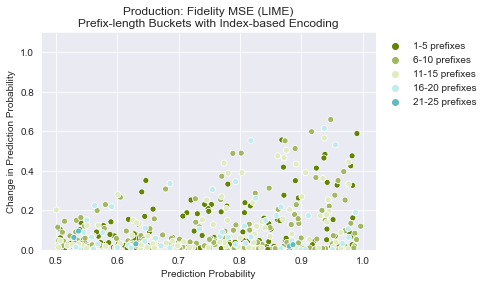

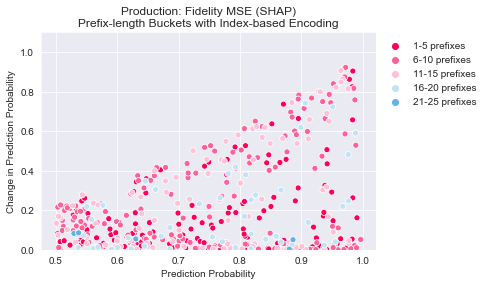

In [19]:
sns.scatterplot(all_proba, all_lime_MSE, hue=hue_lens, palette = lime_pal[:pal_len])
plt.xlabel("Prediction Probability")
plt.ylabel("Change in Prediction Probability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.ylim(0,1.1)
plt.title("Production: Fidelity MSE (LIME)\nPrefix-length Buckets with Index-based Encoding")
plt.show()

sns.scatterplot(all_proba, all_shap_MSE, hue=hue_lens, palette = shap_pal[:pal_len])
plt.xlabel("Prediction Probability")
plt.ylabel("Change in Prediction Probability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.ylim(0,1.1)
plt.title("Production: Fidelity MSE (SHAP)\nPrefix-length Buckets with Index-based Encoding")
plt.show()

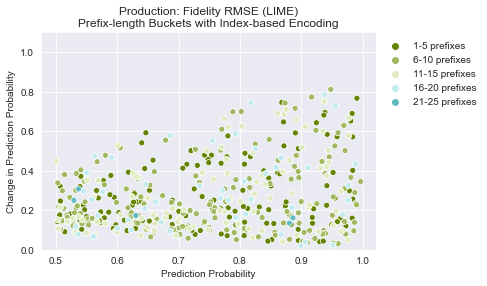

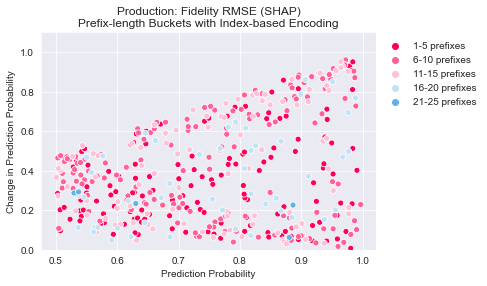

In [20]:
sns.scatterplot(all_proba, all_lime_RMSE, hue = hue_lens, palette = lime_pal[:pal_len])
plt.xlabel("Prediction Probability")
plt.ylabel("Change in Prediction Probability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.ylim(0,1.1)
plt.title("Production: Fidelity RMSE (LIME)\nPrefix-length Buckets with Index-based Encoding")
plt.show()

sns.scatterplot(all_proba, all_shap_RMSE, hue = hue_lens, palette = shap_pal[:pal_len])
plt.xlabel("Prediction Probability")
plt.ylabel("Change in Prediction Probability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.ylim(0,1.1)
plt.title("Production: Fidelity RMSE (SHAP)\nPrefix-length Buckets with Index-based Encoding")
plt.show()

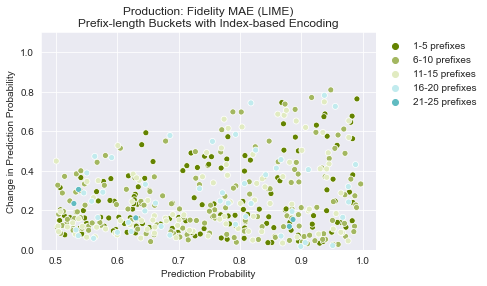

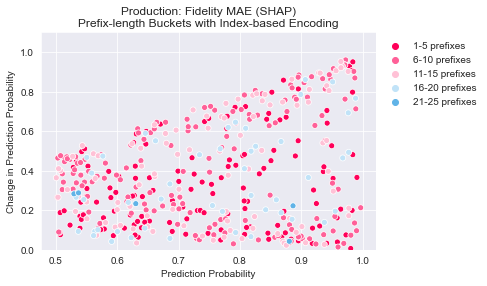

In [21]:
lime_scat = sns.scatterplot(all_proba, all_lime_MAE, hue = hue_lens, palette = lime_pal[:pal_len])
plt.xlabel("Prediction Probability")
plt.ylabel("Change in Prediction Probability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.ylim(0,1.1)
plt.title("Production: Fidelity MAE (LIME)\nPrefix-length Buckets with Index-based Encoding")
plot = lime_scat.get_figure()
plot.savefig("figures/lime_fidelity_mae.png", bbox_inches = "tight")
plt.show()

shap_scat = sns.scatterplot(all_proba, all_shap_MAE, hue = hue_lens, palette = shap_pal[:pal_len])
plt.xlabel("Prediction Probability")
plt.ylabel("Change in Prediction Probability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.ylim(0,1.1)
plt.title("Production: Fidelity MAE (SHAP)\nPrefix-length Buckets with Index-based Encoding")
plot = shap_scat.get_figure()
plot.savefig("figures/shap_fidelity_mae.png", bbox_inches = "tight")
plt.show()

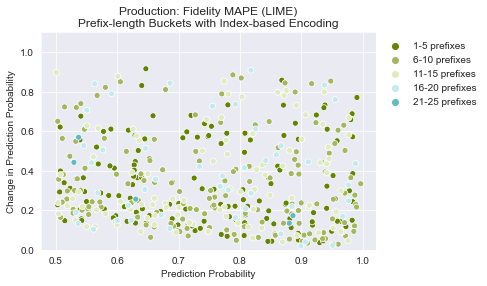

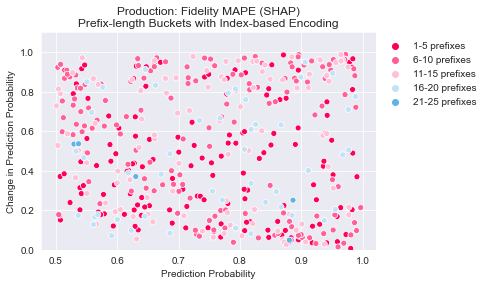

In [22]:
lime_scat = sns.scatterplot(all_proba, all_lime_MAPE, hue = hue_lens, palette = lime_pal[:pal_len])
plt.xlabel("Prediction Probability")
plt.ylabel("Change in Prediction Probability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.ylim(0,1.1)
plt.title("Production: Fidelity MAPE (LIME)\nPrefix-length Buckets with Index-based Encoding")
plot = lime_scat.get_figure()
plot.savefig("figures/lime_fidelity_mape.png", bbox_inches = "tight")
plt.show()

shap_scat = sns.scatterplot(all_proba, all_shap_MAPE, hue = hue_lens, palette = shap_pal[:pal_len])
plt.xlabel("Prediction Probability")
plt.ylabel("Change in Prediction Probability")
plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.ylim(0,1.1)
plt.title("Production: Fidelity MAPE (SHAP)\nPrefix-length Buckets with Index-based Encoding")
plot = shap_scat.get_figure()
plot.savefig("figures/shap_fidelity_mape.png", bbox_inches = "tight")
plt.show()

In [23]:
max_len = max(all_lengths)
bins = np.arange(0, max_len+10, 5)
labels = []
for i in range(len(bins)-1):
    start = str(int(bins[i]+1))
    end = str(int(bins[i+1]))
    label = start+"-"+end+" prefixes"
    labels.append(label)

sep_hues = [[],[],[],[]]

for i in range(len(sep_lengths)): 
    for length in sep_lengths[i]:
        cur_bin = 0
        while length >= bins[cur_bin+1]:
            cur_bin += 1
        sep_hues[i].append(labels[cur_bin])
#sep_hues

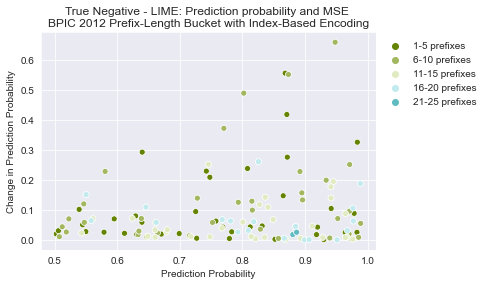

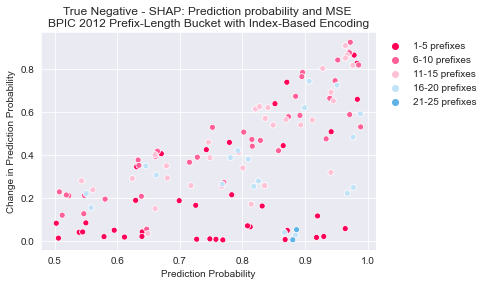

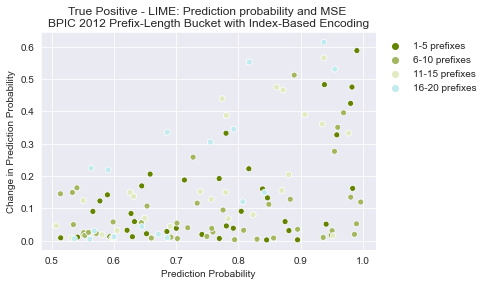

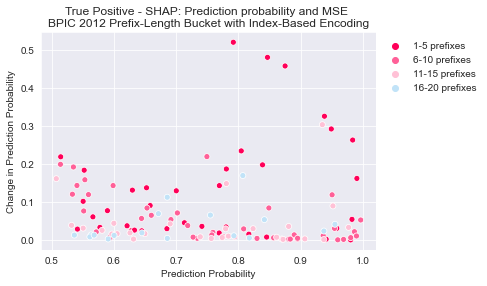

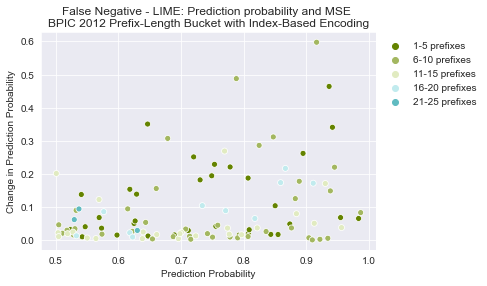

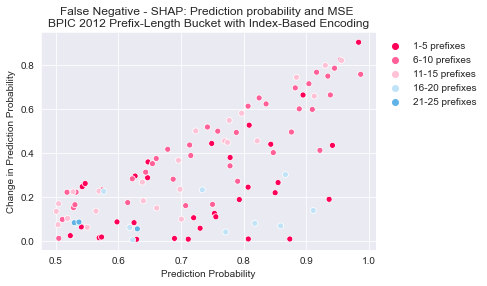

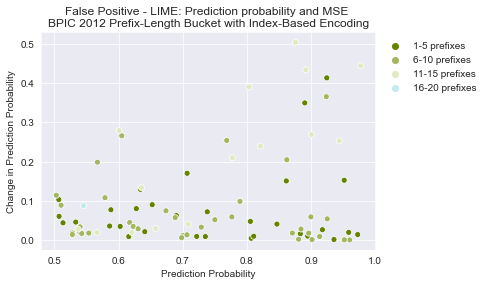

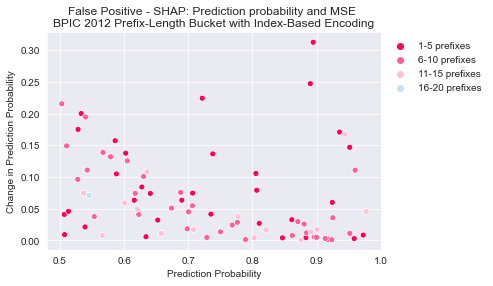

In [24]:
type_list = ['True Negative', 'True Positive', 'False Negative', 'False Positive']

for i in range(len(type_list)):
    sns.scatterplot(sep_proba[i], sep_lime_MSE[i], hue = sep_hues[i], palette = lime_pal[:len(set(sep_hues[i]))])
    plt.xlabel("Prediction Probability")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+" - LIME: Prediction probability and MSE \nBPIC 2012 Prefix-Length Bucket with Index-Based Encoding")
    plt.show()

    sns.scatterplot(sep_proba[i], sep_shap_MSE[i], hue = sep_hues[i], palette = shap_pal[:len(set(sep_hues[i]))])
    plt.xlabel("Prediction Probability")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+" - SHAP: Prediction probability and MSE \nBPIC 2012 Prefix-Length Bucket with Index-Based Encoding")
    plt.show()

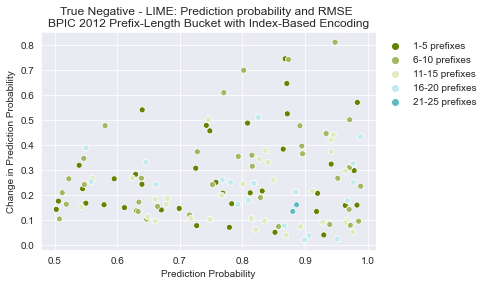

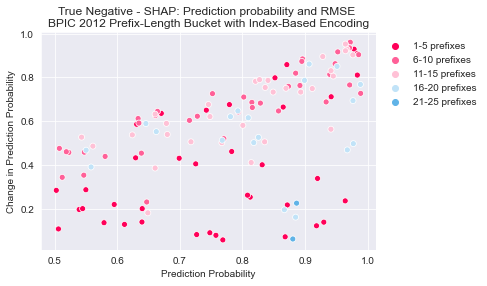

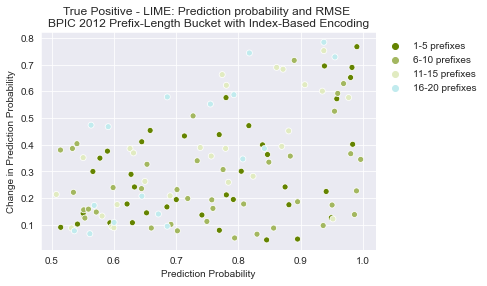

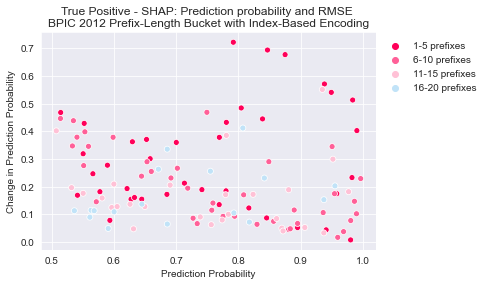

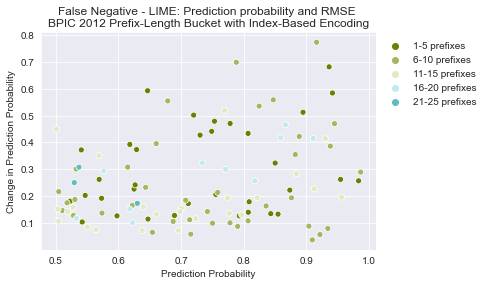

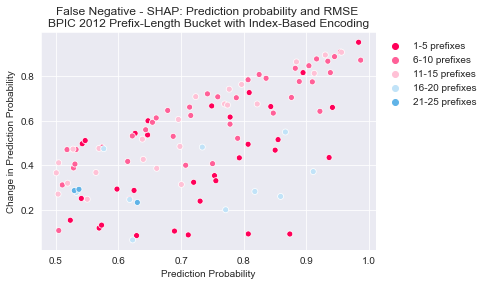

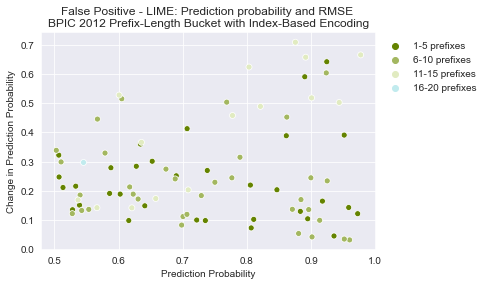

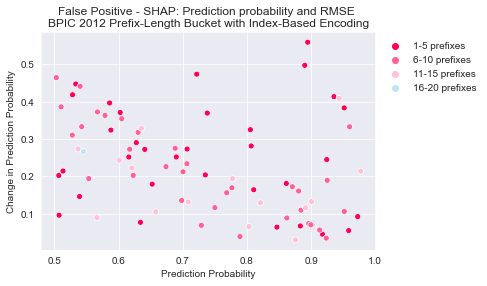

In [25]:
type_list = ['True Negative', 'True Positive', 'False Negative', 'False Positive']

for i in range(len(type_list)):
    sns.scatterplot(sep_proba[i], sep_lime_RMSE[i], hue = sep_hues[i], palette = lime_pal[:len(set(sep_hues[i]))])
    plt.xlabel("Prediction Probability")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+" - LIME: Prediction probability and RMSE \nBPIC 2012 Prefix-Length Bucket with Index-Based Encoding")
    plt.show()

    sns.scatterplot(sep_proba[i], sep_shap_RMSE[i], hue = sep_hues[i], palette = shap_pal[:len(set(sep_hues[i]))])
    plt.xlabel("Prediction Probability")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+" - SHAP: Prediction probability and RMSE \nBPIC 2012 Prefix-Length Bucket with Index-Based Encoding")
    plt.show()


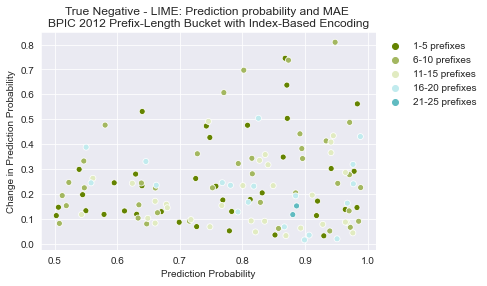

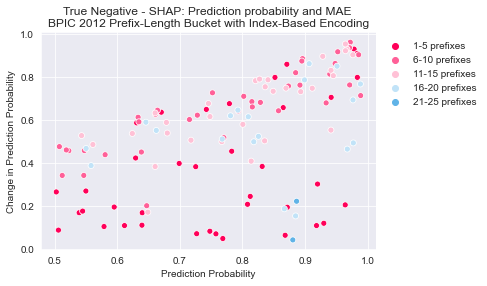

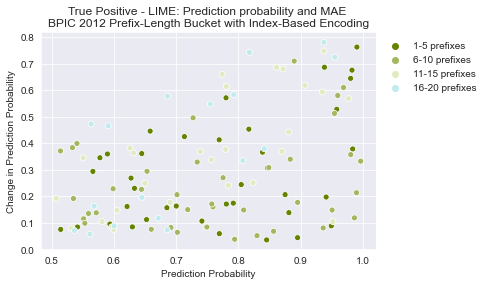

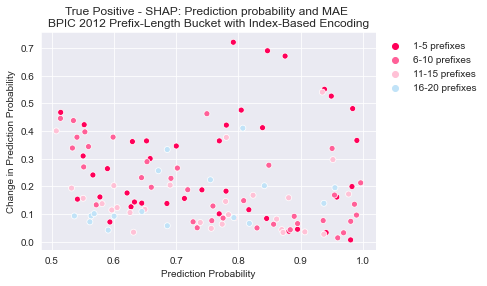

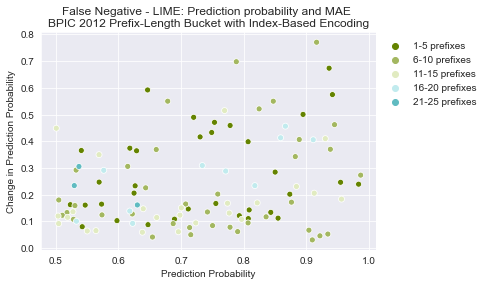

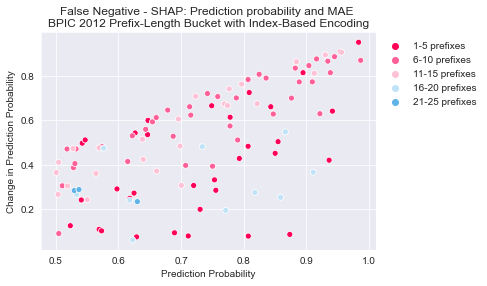

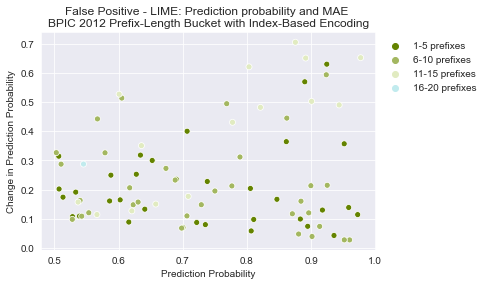

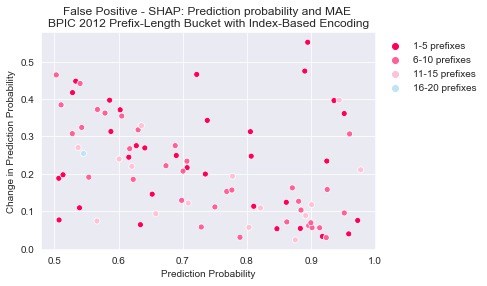

In [26]:
type_list = ['True Negative', 'True Positive', 'False Negative', 'False Positive']

for i in range(len(type_list)):
    sns.scatterplot(sep_proba[i], sep_lime_MAE[i], hue = sep_hues[i], palette = lime_pal[:len(set(sep_hues[i]))])
    plt.xlabel("Prediction Probability")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+" - LIME: Prediction probability and MAE \nBPIC 2012 Prefix-Length Bucket with Index-Based Encoding")
    plt.show()

    sns.scatterplot(sep_proba[i], sep_shap_MAE[i], hue = sep_hues[i], palette = shap_pal[:len(set(sep_hues[i]))])
    plt.xlabel("Prediction Probability")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+" - SHAP: Prediction probability and MAE \nBPIC 2012 Prefix-Length Bucket with Index-Based Encoding")
    plt.show()


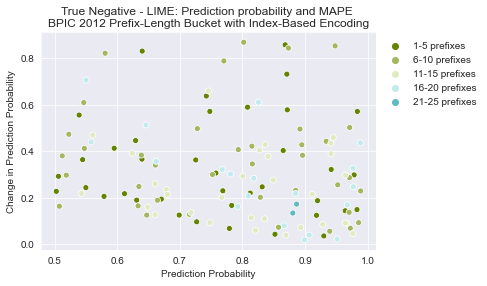

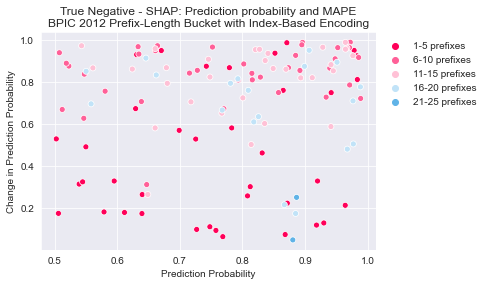

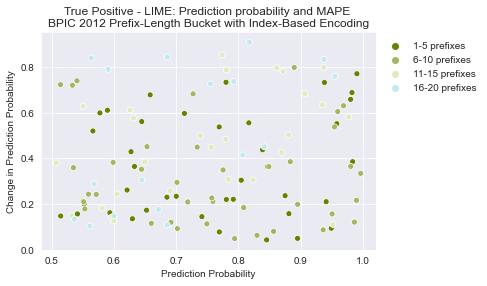

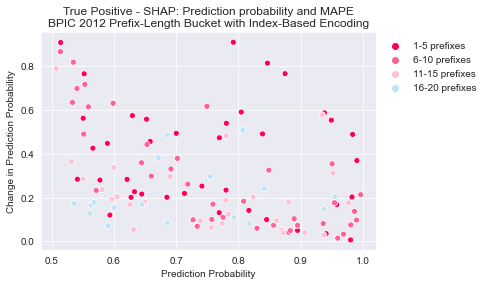

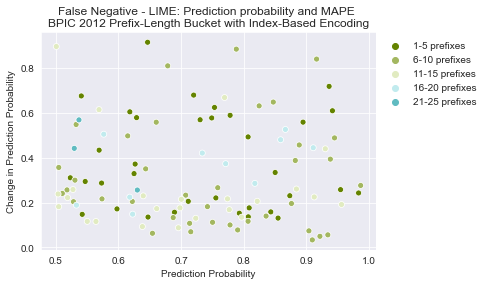

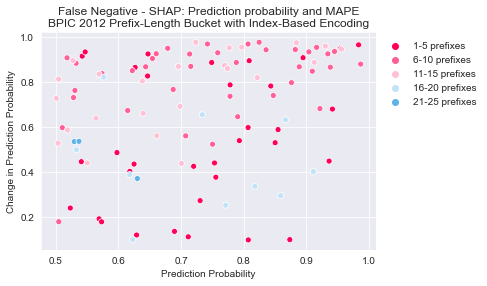

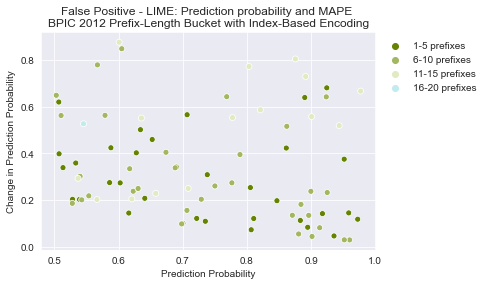

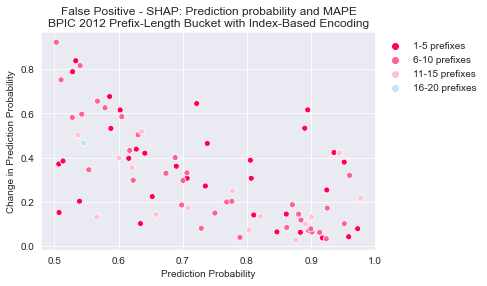

In [27]:
type_list = ['True Negative', 'True Positive', 'False Negative', 'False Positive']

for i in range(len(type_list)):
    sns.scatterplot(sep_proba[i], sep_lime_MAPE[i], hue = sep_hues[i], palette = lime_pal[:len(set(sep_hues[i]))])
    plt.xlabel("Prediction Probability")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+" - LIME: Prediction probability and MAPE \nBPIC 2012 Prefix-Length Bucket with Index-Based Encoding")
    plt.show()

    sns.scatterplot(sep_proba[i], sep_shap_MAPE[i], hue = sep_hues[i], palette = shap_pal[:len(set(sep_hues[i]))])
    plt.xlabel("Prediction Probability")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+" - SHAP: Prediction probability and MAPE\nBPIC 2012 Prefix-Length Bucket with Index-Based Encoding")
    plt.show()


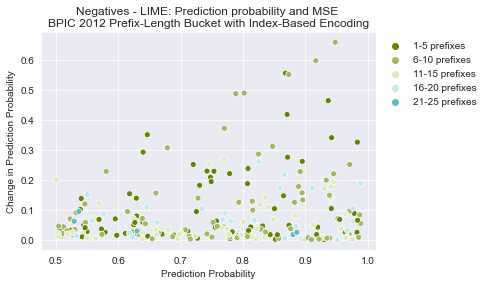

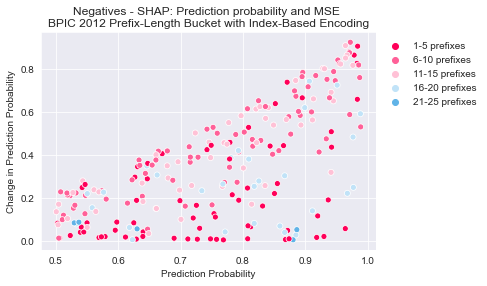

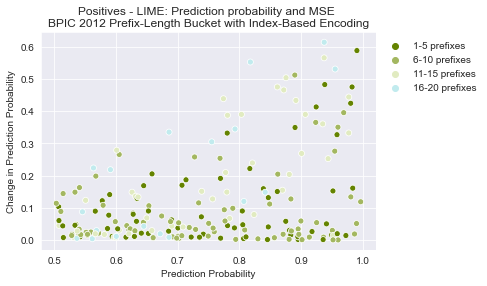

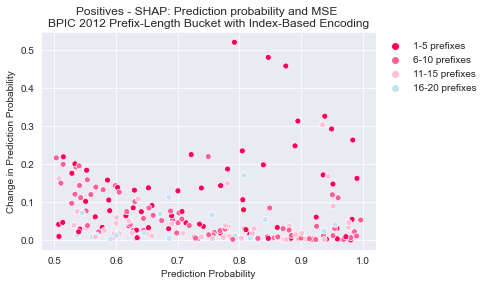

In [28]:
type_list = ['Negatives', 'Positives']

type_lengths = [[],[]]
type_proba = [[],[]]
type_hues = [[],[]]

type_lengths[0].extend(sep_lengths[0])
type_lengths[0].extend(sep_lengths[2])
type_lengths[1].extend(sep_lengths[1])
type_lengths[1].extend(sep_lengths[3])

type_proba[0].extend(sep_proba[0])
type_proba[0].extend(sep_proba[2])
type_proba[1].extend(sep_proba[1])
type_proba[1].extend(sep_proba[3])

type_hues[0].extend(sep_hues[0])
type_hues[0].extend(sep_hues[2])
type_hues[1].extend(sep_hues[1])
type_hues[1].extend(sep_hues[3])

type_lime_MSE = [[],[]]
type_shap_MSE = [[],[]]

type_lime_MSE[0].extend(sep_lime_MSE[0])
type_lime_MSE[0].extend(sep_lime_MSE[2])
type_lime_MSE[1].extend(sep_lime_MSE[1])
type_lime_MSE[1].extend(sep_lime_MSE[3])

type_shap_MSE[0].extend(sep_shap_MSE[0])
type_shap_MSE[0].extend(sep_shap_MSE[2])
type_shap_MSE[1].extend(sep_shap_MSE[1])
type_shap_MSE[1].extend(sep_shap_MSE[3])

for i in range(len(type_list)):
    sns.scatterplot(type_proba[i], type_lime_MSE[i], hue = type_hues[i], palette = lime_pal[:len(set(type_hues[i]))])
    plt.xlabel("Prediction Probability")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+" - LIME: Prediction probability and MSE \nBPIC 2012 Prefix-Length Bucket with Index-Based Encoding")
    plt.show()

    sns.scatterplot(type_proba[i], type_shap_MSE[i], hue = type_hues[i], palette = shap_pal[:len(set(type_hues[i]))])
    plt.xlabel("Prediction Probability")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+" - SHAP: Prediction probability and MSE \nBPIC 2012 Prefix-Length Bucket with Index-Based Encoding")
    plt.show()


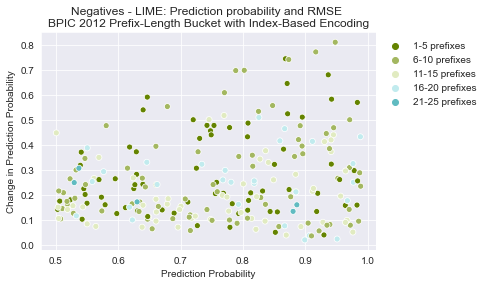

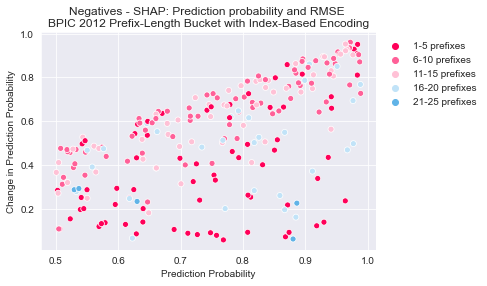

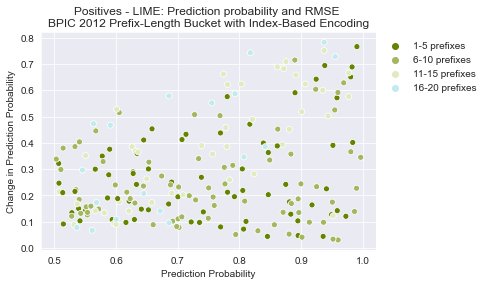

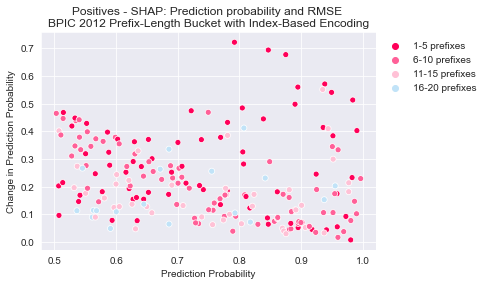

In [29]:
type_list = ['Negatives', 'Positives']

type_lengths = [[], []]
type_proba = [[],[]]

type_lengths[0].extend(sep_lengths[0])
type_lengths[0].extend(sep_lengths[2])
type_lengths[1].extend(sep_lengths[1])
type_lengths[1].extend(sep_lengths[3])

type_proba[0].extend(sep_proba[0])
type_proba[0].extend(sep_proba[2])
type_proba[1].extend(sep_proba[1])
type_proba[1].extend(sep_proba[3])

type_lime_RMSE = [[],[]]
type_shap_RMSE = [[],[]]

type_lime_RMSE[0].extend(sep_lime_RMSE[0])
type_lime_RMSE[0].extend(sep_lime_RMSE[2])
type_lime_RMSE[1].extend(sep_lime_RMSE[1])
type_lime_RMSE[1].extend(sep_lime_RMSE[3])

type_shap_RMSE[0].extend(sep_shap_RMSE[0])
type_shap_RMSE[0].extend(sep_shap_RMSE[2])
type_shap_RMSE[1].extend(sep_shap_RMSE[1])
type_shap_RMSE[1].extend(sep_shap_RMSE[3])

for i in range(len(type_list)):
    sns.scatterplot(type_proba[i], type_lime_RMSE[i], hue = type_hues[i], palette = lime_pal[:len(set(type_hues[i]))])
    plt.xlabel("Prediction Probability")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+" - LIME: Prediction probability and RMSE \nBPIC 2012 Prefix-Length Bucket with Index-Based Encoding")
    plt.show()

    sns.scatterplot(type_proba[i], type_shap_RMSE[i], hue = type_hues[i], palette = shap_pal[:len(set(type_hues[i]))])
    plt.xlabel("Prediction Probability")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+" - SHAP: Prediction probability and RMSE \nBPIC 2012 Prefix-Length Bucket with Index-Based Encoding")
    plt.show()


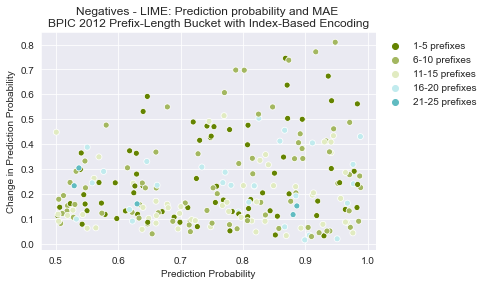

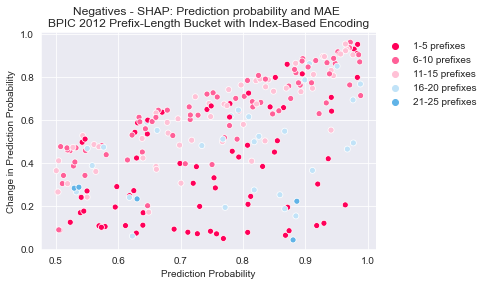

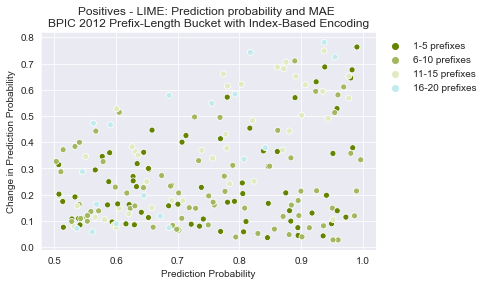

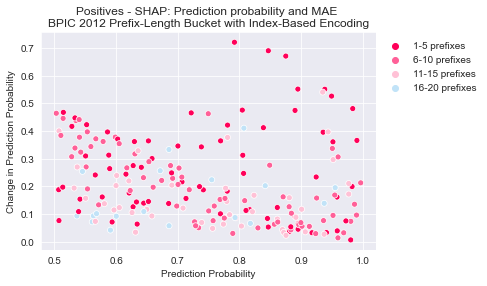

In [30]:
type_list = ['Negatives', 'Positives']

type_lengths = [[], []]
type_proba = [[],[]]

type_lengths[0].extend(sep_lengths[0])
type_lengths[0].extend(sep_lengths[2])
type_lengths[1].extend(sep_lengths[1])
type_lengths[1].extend(sep_lengths[3])

type_proba[0].extend(sep_proba[0])
type_proba[0].extend(sep_proba[2])
type_proba[1].extend(sep_proba[1])
type_proba[1].extend(sep_proba[3])

type_lime_MAE = [[],[]]
type_shap_MAE = [[],[]]

type_lime_MAE[0].extend(sep_lime_MAE[0])
type_lime_MAE[0].extend(sep_lime_MAE[2])
type_lime_MAE[1].extend(sep_lime_MAE[1])
type_lime_MAE[1].extend(sep_lime_MAE[3])

type_shap_MAE[0].extend(sep_shap_MAE[0])
type_shap_MAE[0].extend(sep_shap_MAE[2])
type_shap_MAE[1].extend(sep_shap_MAE[1])
type_shap_MAE[1].extend(sep_shap_MAE[3])

for i in range(len(type_list)):
    sns.scatterplot(type_proba[i], type_lime_MAE[i], hue = type_hues[i], palette = lime_pal[:len(set(type_hues[i]))])
    plt.xlabel("Prediction Probability")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+" - LIME: Prediction probability and MAE \nBPIC 2012 Prefix-Length Bucket with Index-Based Encoding")
    plt.show()

    sns.scatterplot(type_proba[i], type_shap_MAE[i], hue = type_hues[i], palette = shap_pal[:len(set(type_hues[i]))])
    plt.xlabel("Prediction Probability")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+" - SHAP: Prediction probability and MAE \nBPIC 2012 Prefix-Length Bucket with Index-Based Encoding")
    plt.show()


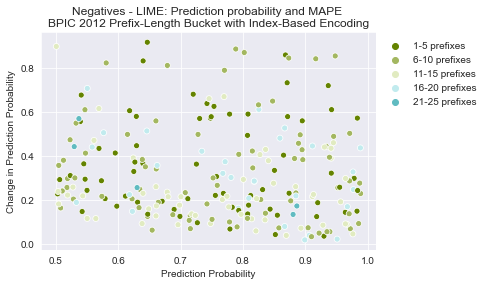

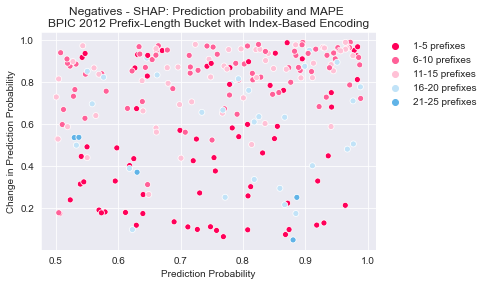

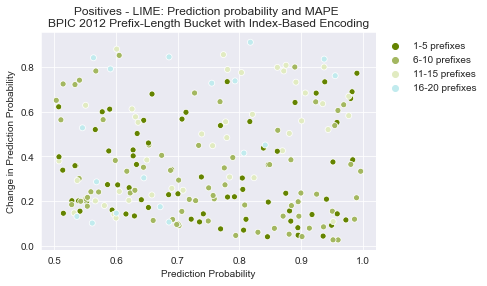

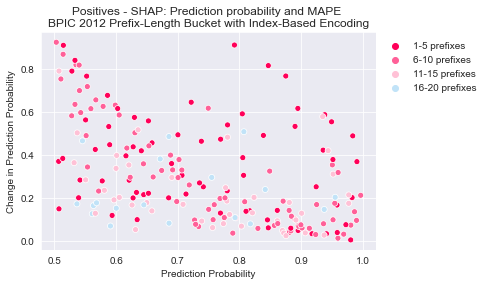

In [31]:
type_list = ['Negatives', 'Positives']

type_lengths = [[], []]
type_proba = [[],[]]

type_lengths[0].extend(sep_lengths[0])
type_lengths[0].extend(sep_lengths[2])
type_lengths[1].extend(sep_lengths[1])
type_lengths[1].extend(sep_lengths[3])

type_proba[0].extend(sep_proba[0])
type_proba[0].extend(sep_proba[2])
type_proba[1].extend(sep_proba[1])
type_proba[1].extend(sep_proba[3])

type_lime_MAPE = [[],[]]
type_shap_MAPE = [[],[]]

type_lime_MAPE[0].extend(sep_lime_MAPE[0])
type_lime_MAPE[0].extend(sep_lime_MAPE[2])
type_lime_MAPE[1].extend(sep_lime_MAPE[1])
type_lime_MAPE[1].extend(sep_lime_MAPE[3])

type_shap_MAPE[0].extend(sep_shap_MAPE[0])
type_shap_MAPE[0].extend(sep_shap_MAPE[2])
type_shap_MAPE[1].extend(sep_shap_MAPE[1])
type_shap_MAPE[1].extend(sep_shap_MAPE[3])

for i in range(len(type_list)):
    sns.scatterplot(type_proba[i], type_lime_MAPE[i], hue = type_hues[i], palette = lime_pal[:len(set(type_hues[i]))])
    plt.xlabel("Prediction Probability")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+" - LIME: Prediction probability and MAPE \nBPIC 2012 Prefix-Length Bucket with Index-Based Encoding")
    plt.show()

    sns.scatterplot(type_proba[i], type_shap_MAPE[i], hue = type_hues[i], palette = shap_pal[:len(set(type_hues[i]))])
    plt.xlabel("Prediction Probability")
    plt.ylabel("Change in Prediction Probability")
    plt.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
    #plt.yticks(np.arange(0,15,1))
    plt.title(type_list[i]+" - SHAP: Prediction probability and MAPE \nBPIC 2012 Prefix-Length Bucket with Index-Based Encoding")
    plt.show()


In [32]:
print("Average LIME MSE:", np.mean(all_lime_MSE))
print("Average SHAP MSE:", np.mean(all_shap_MSE))
print("\n")

print("Average LIME RMSE:", np.mean(all_lime_RMSE))
print("Average SHAP RMSE:", np.mean(all_shap_RMSE))
print("\n")

print("Average LIME MAE:", np.mean(all_lime_MAE))
print("Average SHAP MAE:", np.mean(all_shap_MAE))
print("\n")

print("Average LIME MAPE:", np.mean(all_lime_MAPE))
print("Average SHAP MAPE:", np.mean(all_shap_MAPE))
print("\n")

print("LIME Fidelity:", np.mean(all_lime_MAPE))
print("SHAP Fidelity:", np.mean(all_shap_MAPE))

Average LIME MSE: 0.10660000379959725
Average SHAP MSE: 0.21657136725414106


Average LIME RMSE: 0.27381805821783317
Average SHAP RMSE: 0.38877355067292774


Average LIME MAE: 0.2570385264257982
Average SHAP MAE: 0.37979772604253503


Average LIME MAPE: 0.34376828026350076
Average SHAP MAPE: 0.5080608320400524


LIME Fidelity: 0.34376828026350076
SHAP Fidelity: 0.5080608320400524


In [33]:
print(len(all_lime_MSE))

443
